In [1]:
! which python

/Users/no_lineal/opt/anaconda3/envs/grid38/bin/python


In [2]:
import numpy as np

from scipy.ndimage import maximum_filter
from scipy.signal import find_peaks

from tqdm import tqdm

import os

# viz
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [3]:
"""

    where am i?

"""

PATH = os.getcwd()
precomputed_path = PATH + '/precomputed/'

print( f'PATH: { PATH }' )
print( f'precomputed path: { precomputed_path }' )

PATH: /Users/no_lineal/Documents/GitHub/dm-grid-cells
precomputed path: /Users/no_lineal/Documents/GitHub/dm-grid-cells/precomputed/


In [4]:
""" 

    load dataset

"""

res = np.load( precomputed_path + 'res/' + 'res_999.npy', allow_pickle=True, encoding='latin1' )
res = dict( res.item() )
scores = np.load( precomputed_path + 'scores/' + 'scores_999.npy', allow_pickle=True, encoding='latin1' )
scores = dict( scores.item() )
log_info = np.load( precomputed_path + 'log_info/' + 'log_info_999.npy', allow_pickle=True, encoding='latin1' )
log_info = dict( log_info.item() )

s = np.load( precomputed_path + 's_20.npy', allow_pickle=True, encoding='latin1' )
max_60_mask = np.load( precomputed_path + 'max_60_mask_20.npy', allow_pickle=True, encoding='latin1' )
max_90_mask = np.load( precomputed_path + 'max_90_mask_20.npy', allow_pickle=True, encoding='latin1' )
sac = np.load( precomputed_path + 'sac_20.npy', allow_pickle=True, encoding='latin1' )
score_60 = np.load( precomputed_path + 'score_60_20.npy', allow_pickle=True, encoding='latin1' )
score_90 = np.load( precomputed_path + 'score_90_20.npy', allow_pickle=True, encoding='latin1' )

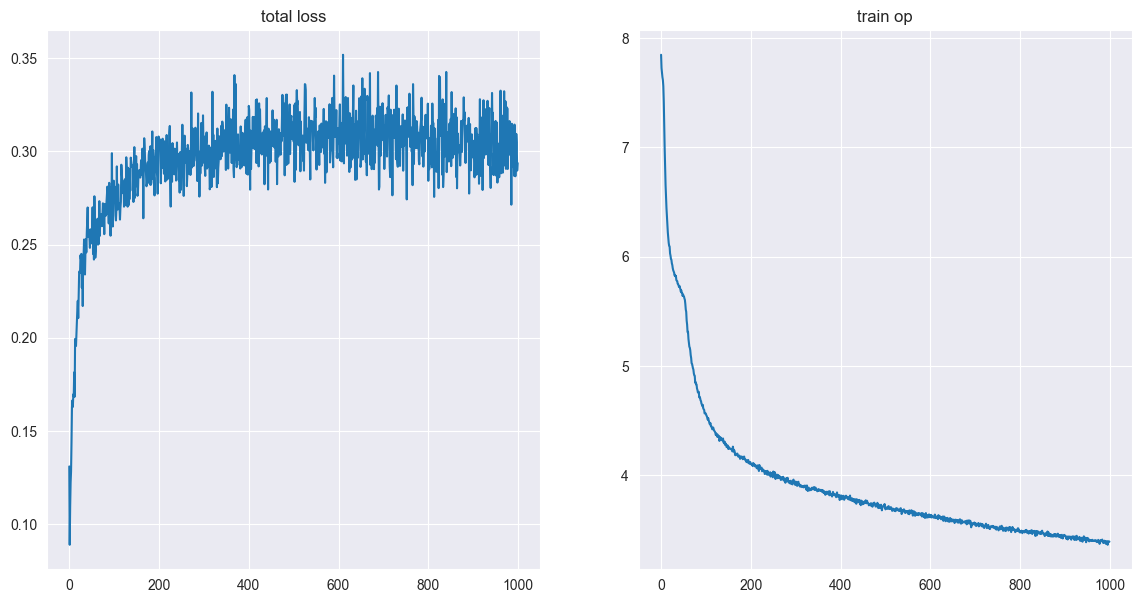

In [5]:
""" 

    loss viz

"""

fig, axs = plt.subplots( 1 , 2, figsize=( 14, 7 ) )

axs[ 0 ].plot( log_info['total_loss'] )
axs[ 0 ].set_title( 'total loss' )

axs[ 1 ].plot( log_info['train_op'] )
axs[ 1 ].set_title( 'train op' )

plt.show()

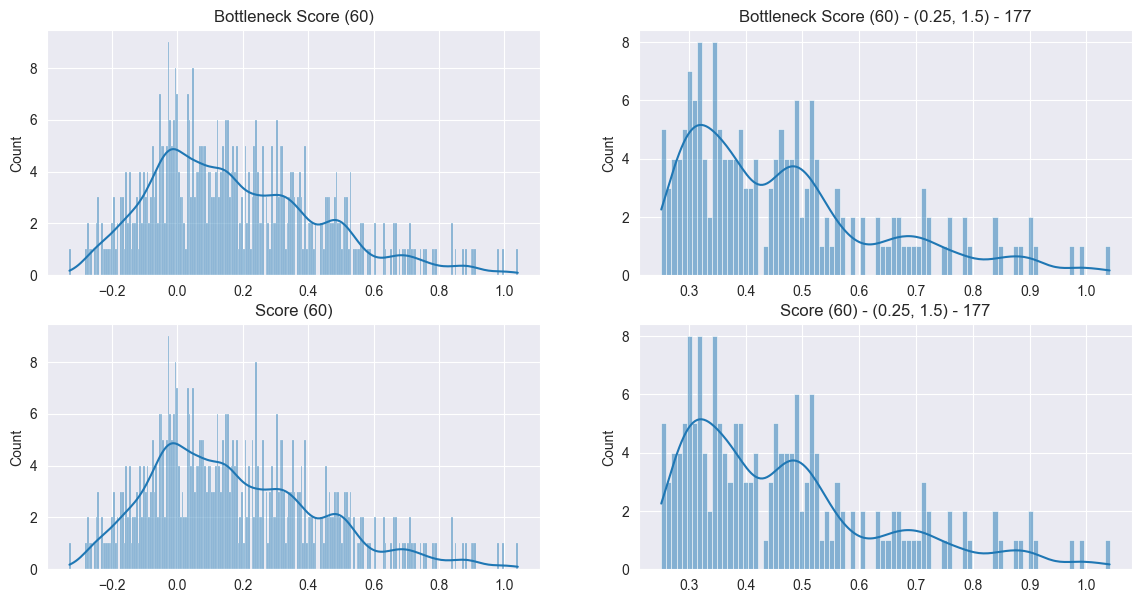

In [6]:
"""

    frozen score

"""

lb_th = 0.25
ub_th = 1.5

btln_60 = scores[ 'btln_60' ]

btln_60_top_idx = np.where( ( lb_th <= btln_60 ) & ( btln_60 <= ub_th ) )[0]
btln_60_top = btln_60[ btln_60_top_idx ]

score_60_top_idx = np.where( ( lb_th <= score_60 ) & ( score_60 <= ub_th ) )[0]
score_60_top = score_60[ score_60_top_idx ]

fig, axs = plt.subplots( 2 , 2, figsize=( 14, 7 ) )

hist = sns.histplot( btln_60 , bins=int( len( btln_60 ) / 2 ), kde=True, kde_kws={'bw_adjust': 0.5}, ax=axs[0, 0])
axs[ 0, 0 ].set_title( 'Bottleneck Score (60)' )

hist = sns.histplot( btln_60_top , bins=int( len( btln_60_top ) / 2 ), kde=True, kde_kws={'bw_adjust': 0.5}, ax=axs[0, 1])
axs[ 0, 1 ].set_title( f'Bottleneck Score (60) - {lb_th, ub_th} - {len(btln_60_top)}' )

hist = sns.histplot( score_60 , bins=int( len( score_60 ) / 2 ), kde=True, kde_kws={'bw_adjust': 0.5}, ax=axs[1, 0])
axs[ 1, 0 ].set_title( 'Score (60)' )

hist = sns.histplot( score_60_top , bins=int( len( score_60_top ) / 2 ), kde=True, kde_kws={'bw_adjust': 0.5}, ax=axs[1, 1])
axs[ 1, 1 ].set_title( f'Score (60) - {lb_th, ub_th} - {len(score_60_top)}' )

plt.show()

In [7]:
"""

    peak filter

"""

def peak_filter( sac, hc_center=True, footprint=(50, 50) ):

    global_max = []
    local_max = []
    distances = []
    
    for s in tqdm(sac):

        if hc_center:

            center = s.shape[0] // 2
            global_max_pos = ( center, center )

        else:

            global_max_pos = np.unravel_index( s.argmax(), s.shape )

        local_max_pos = maximum_filter(s, footprint=np.ones( footprint ), mode='wrap')
        dists = [ np.linalg.norm( np.array( global_max_pos ) - np.array( pos ) ) for pos in np.argwhere( local_max_pos == s ) ]

        global_max.append( global_max_pos )
        local_max.append( local_max_pos )
        distances.append( dists )

    return global_max, local_max, distances
        
sac = np.array( sac )
global_max, local_max, dists = peak_filter( sac, footprint=( 5, 5 ) )

print( f'sac: { sac.shape }' )
print( f'global_max: { len(global_max) }' )
print( f'local_max: { len(local_max) }' )
print( f'dists: { len(dists) }' )

100%|██████████| 512/512 [00:00<00:00, 6977.27it/s]

sac: (512, 39, 39)
global_max: 512
local_max: 512
dists: 512



sample s: (177, 20, 20)
sample sac: (177, 39, 39)
sample gm: (177, 2)
sample lm: 177
sample dists: 177
score idx: (177,)
score top idx: [21, 172, 57, 79, 12, 165, 160, 115, 47, 113]
score top flip idx: [161, 137, 54, 75, 35, 85, 166, 84, 86, 11]



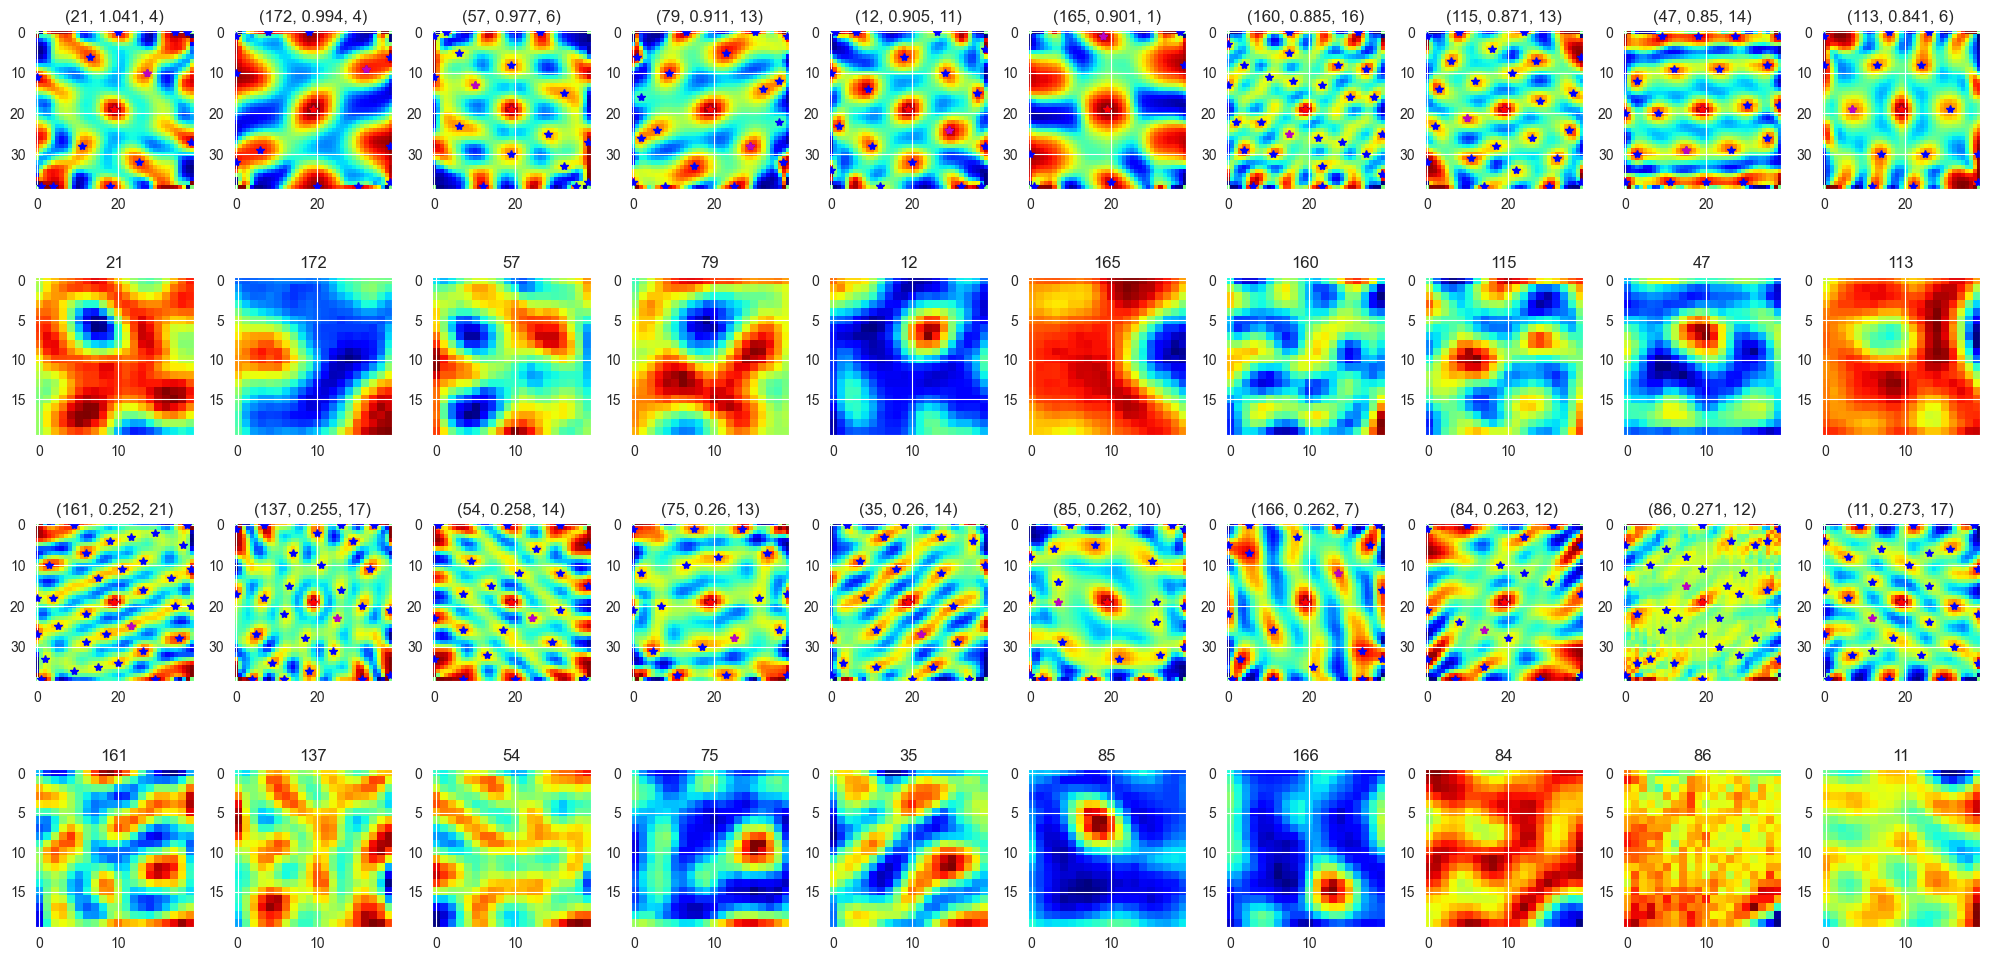

In [8]:
"""  

    viz top k

"""

def sort_max_score( score ):

    idxs = np.flip( np.argsort( score ) )

    return idxs

k = 10

score_idx = sort_max_score( score_60_top )
score_top_flip_idx = np.flip( sort_max_score( score_60_top ) )

score_top_flip_idx = list( score_top_flip_idx[:k] )
score_top_idx = list(score_idx[:k])

sample_sac = sac[ score_60_top_idx ]

sample_gm = np.array( global_max )[ score_60_top_idx ]

sample_lm = np.array( local_max )[ score_60_top_idx ]
sample_lm = [ np.argwhere( sample_lm[i] == sample_sac[i] ) for i in range( sample_sac.shape[0] ) ]

sample_dists = [ dists[ idx ] for idx in score_60_top_idx ]

sample_s = s[ score_60_top_idx ]

print('')
print( f'sample s: { sample_s.shape }' )
print( f'sample sac: { sample_sac.shape }' )
print( f'sample gm: { sample_gm.shape }' )
print( f'sample lm: { len(sample_lm) }' )
print( f'sample dists: { len(sample_dists) }' )
print( f'score idx: { score_idx.shape }' )
print( f'score top idx: { score_top_idx }' )
print( f'score top flip idx: { score_top_flip_idx }' )
print('')

fig, axs = plt.subplots( 4 , k, figsize=( 20, 10 ) )

for i, idx in enumerate( score_top_idx ):

    ad = sample_dists[ idx ]
    al = sample_lm[ idx ]    

    ad = np.argsort( ad )[1]
    al = al[ ad ]

    axs[ 0, i ].imshow( sample_sac[ idx ], cmap='jet' )
    axs[ 0, i ].plot( sample_lm[ idx ][:,1], sample_lm[ idx ][:,0], 'b*' )
    axs[ 0, i ].plot( sample_gm[ idx ][1], sample_gm[ idx ][0], 'r*' )
    axs[ 0, i ].plot( al[1], al[0], 'm*' )
    axs[ 0, i ].set_title( f'{  idx, round( score_60_top[ idx ], 3 ), np.min( ad ) }' )

for i, idx in enumerate( score_top_idx ):

    axs[ 1, i ].imshow( sample_s[ idx ], cmap='jet' )
    axs[ 1, i ].set_title( f'{  idx }' )

for i, idx in enumerate(score_top_flip_idx):

    ad = sample_dists[ idx ]
    al = sample_lm[ idx ]    

    ad = np.argsort( ad )[1]
    al = al[ ad ]

    axs[ 2, i ].imshow( sample_sac[ idx ], cmap='jet' )
    axs[ 2, i ].plot( sample_lm[ idx ][:,1], sample_lm[ idx ][:,0], 'b*' )
    axs[ 2, i ].plot( sample_gm[ idx ][1], sample_gm[ idx ][0], 'r*' )
    axs[ 2, i ].plot( al[1], al[0], 'm*' )
    axs[ 2, i ].set_title( f'{  idx, round( score_60_top[ idx ], 3 ), np.min( ad ) }' )

for i, idx in enumerate(score_top_flip_idx):

    axs[ 3, i ].imshow( sample_s[ idx ], cmap='jet' )
    axs[ 3, i ].set_title( f'{  idx }' )

plt.tight_layout()
plt.show()

dist top: 177

[ 42  84 170]
[0.48547811 0.67095623 1.05074474]

[ 42  84 170]
[39, 92, 172]
[0.47222968 0.70628539 1.05957703]

[ 42  84 170]
[41, 97, 175]
[0.48106197 0.72836612 1.07282547]


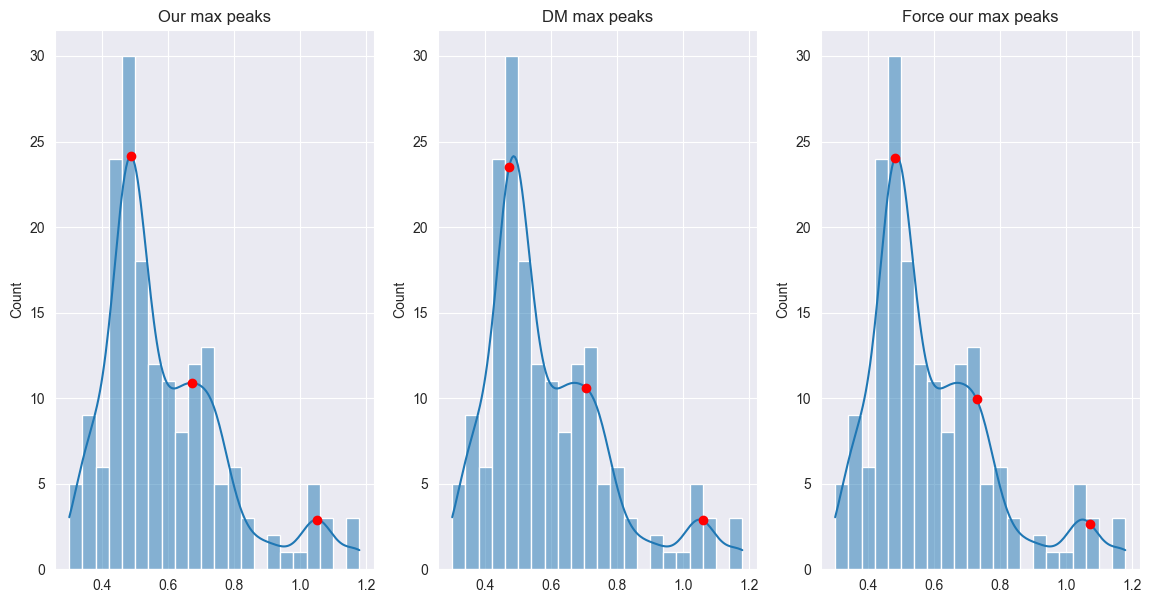

In [9]:
dists_top = [ (np.array(dists[idx]) * 6) / 100 for idx in score_60_top_idx ]

print( f'dist top: { len( dists_top ) }' )
print('')

dists_top_min = [ np.min( x[ np.nonzero(x)[0] ] ) for x in dists_top ]
dists_top_mean = [ np.mean(np.sort(x[ np.nonzero(x)[0] ])[:2]) for x in dists_top ]

fig, axs = plt.subplots( 1 , 3, figsize=( 14, 7 ) )


hist = sns.histplot(dists_top_min, bins=int(len(dists_top) / 8), kde=True, kde_kws={'bw_adjust': 0.6}, ax=axs[0])

peaks, _ = find_peaks( hist.get_lines()[0].get_data()[1] )
print( peaks )
print( hist.get_lines()[0].get_data()[0][peaks] )

hist.plot( hist.get_lines()[0].get_data()[0][peaks], hist.get_lines()[0].get_data()[1][peaks], "ro" )

axs[ 0 ].set_title( 'Our max peaks' )

print( '' )

hist = sns.histplot(dists_top_mean, bins=int(len(dists_top) / 8), kde=True, kde_kws={'bw_adjust': 0.6}, ax=axs[1])

peaks, _ = find_peaks( hist.get_lines()[0].get_data()[1] )
print( peaks )
peaks = [ 39, 92, 172 ]
print( peaks )
print( hist.get_lines()[0].get_data()[0][peaks] ) 

hist.plot( hist.get_lines()[0].get_data()[0][peaks], hist.get_lines()[0].get_data()[1][peaks], "ro" )

axs[ 1 ].set_title( 'DM max peaks' )

print( '' )

hist = sns.histplot(dists_top_mean, bins=int(len(dists_top) / 8), kde=True, kde_kws={'bw_adjust': 0.6}, ax=axs[2])

peaks, _ = find_peaks( hist.get_lines()[0].get_data()[1] )
print( peaks )
peaks = [ 41, 97, 175 ]
print( peaks )
print( hist.get_lines()[0].get_data()[0][peaks] ) 

hist.plot( hist.get_lines()[0].get_data()[0][peaks], hist.get_lines()[0].get_data()[1][peaks], "ro" )

axs[ 2 ].set_title( 'Force our max peaks' )

plt.show()